In [25]:
### If save data:
save_data = False

if save_data:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/

# Import Libraries and Neural Tangents

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.test.gpu_device_name())

import os
import sys
import requests
import numpy as npo
import matplotlib.pyplot as plt
import pandas as pd

## Import Jax and NeuralTangents
#!pip install --upgrade -q jax jaxlib
import jax.numpy as np
import jax
from jax.config import config
from jax import random
from jax.api import jit, grad, vmap
from jax.experimental import optimizers
from jax import device_put

!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

import urllib.request
directory = os.path.join(getcwd(),'GegenbauerEigenvalues.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/GegenbauerEigenvalues.npz"
urllib.request.urlretrieve(url, directory)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_now():
  return datetime.now(pytz.timezone('US/Eastern')).strftime("%m-%d_%H-%M")

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

### Using Time difference
### t_start = datetime.now(pytz.timezone('US/Eastern'))
### t_end = datetime.now(pytz.timezone('US/Eastern'))
### print('Time Elapsed: ' + time_diff(t_start,t_end))

/device:GPU:0


# First Define Your Plot Function

In [27]:
def plot_shift_data(pvals, error, std, Errs_tot, noise_k, noise, directory, timestamp, exp_type, tr_errs = None, save_data = False):
  i = noise_k
  shift = len(noise[i])
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
  for j in range(shift):
      plt.errorbar(pvals, error[i,j], std[i,j], fmt='o', label = r'$\sigma = %.3f$' % noise[i,j], color=colors[j])
      plt.plot(pvals, Errs_tot[j,:,i], color=colors[j])

  if exp_type == 'kernel':
    plt.title('Interpolating Kernel Regression (Infinite Parameters)')
  else:
    plt.title('Neural Network Training')

  plt.xlabel('samples')
  plt.ylabel('test risk')
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()
  label = timestamp + '_k_' + str(i+1) + '_' + 'error_curve_' + exp_type + '.pdf'
  if save_data:  plt.savefig(directory + label, bbox_inches = 'tight')
  plt.show()

# Functions for Data generating and Neural Networks

In [28]:
# generate sphere vectors
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / npo.outer(npo.linalg.norm(x0, axis=1), npo.ones(dim))
  return np.array(x)

## Target function is y(x) = Q_k(beta X)
## It has a single mode and all weights for degenerate modes are the same
def pure_target_fn(X, dim, beta, spectrum, k):
  dim = len(beta)
  lamb = (dim-2)/2
  ## Q(1) from the SI
  Q1 = lamb/(lamb+k)*gegenbauer.degeneracy_kernel(dim, k)

  z = npo.dot(X, beta) 
  d = beta.shape[0]
  y = gegenbauer.gegenbauer(z, dim, d)[k,:]
  # Calculate normalized y:
  y_norm = y*spectrum[k]*((k+lamb)/lamb)

  return np.array(y_norm)

## Target function is y(x) = Q_k(beta X)
## It has a single mode and all weights for degenerate modes are the same
def twolayer_target_fn(X, dim, beta, k):
  dim = len(beta)
  lamb = (dim-2)/2
  ## Q(1) from the SI
  Q1 = lamb/(lamb+k)*gegenbauer.degeneracy_kernel(dim, k)

  z = npo.dot(X, beta) 
  d = beta.shape[0]
  y = gegenbauer.gegenbauer(z, dim, d)[k,:]
  # Calculate normalized y:
  y_norm = y

  return np.array(y_norm)


## Target function is y(x) = Q_k(beta X)
## It has a single mode and all weights for degenerate modes are the same
def n_target_fn(X, dim, beta, k):
  dim = len(beta)
  lamb = (dim-2)/2
  ## Q(1) from the SI
  Q1 = lamb/(lamb+k)*gegenbauer.degeneracy_kernel(dim, k)

  z = npo.dot(X, beta) 
  d = beta.shape[0]
  y = gegenbauer.gegenbauer(z, dim, d)[k,:]
  # Calculate normalized y:
  y_norm = y/Q1

  return np.array(y_norm)

# Generate fully connected NN architecture
def fully_connected(num_layers, width):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = 1, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std = 1, b_std=0)] 
  return stax.serial(*layers)


# Functions for Theory Curves and Experiments


## Theory Curves and NTK Spectrum

In [29]:
def NTK_spectrum(layers, dim, kmax):
  dimension = npo.array([5*(i+1) for i in range(40)])
  degree = npo.array([i for i in range(500)]); 
  layer = npo.array([1, 2, 3, 4, 5, 6, 7, 8, 9]);

  directory = os.path.join(getcwd(),'GegenbauerEigenvalues.npz')
  
  dim_index = npo.where(dimension == dim)[0][0]

  lambda_bar, spectrum = ker_spec.ntk_spectrum(directory, kmax, layer = layers-1, dim = dim_index)
  return lambda_bar, spectrum

def NTK_theory_and_Noise(pvals, layers, dim, kmax, noise_num, shift, fn_mode = 1, zero_mode = False):

  norm = normalization(layers,0,dim)

  ## Generate spectrum and degeneracies
  k = npo.linspace(0,kmax-1,kmax)
  a = (dim-2)/2 
  kp = ((k+a)/a)

  lambda_bar, spectrum = NTK_spectrum(layers, dim, kmax)

  degens = npo.array([gegenbauer.degeneracy_kernel(dim, k) for k in range(kmax)])

  alpha_s = npo.array([(np.sum(lambda_bar[i+1:]))/lambda_bar[i+1] for i in range(kmax-2)])

  noise = npo.zeros((noise_num, len(shift)))
  for i in range(noise_num):
      for j in range(len(shift)):
          if alpha_s[i] >= 2:
              alpha = (alpha_s[i]-1)*(1+shift[j])
              noise[i,j] = (2*alpha+1)*spectrum[i+1]**2*degens[i+1]
          else:
              alpha = (alpha_s[i]-1)*(1+shift[j])+1
              noise[i,j] = ker_sim.noise(alpha)*spectrum[i+1]**2*degens[i+1]

  Sol = npo.zeros((len(shift), len(pvals), kmax, noise_num))
  Errs_tot = npo.zeros((len(shift), len(pvals), noise_num))
  Cum_gen_errs = npo.zeros((len(shift), len(pvals), kmax, noise_num))
  


  for i in range(len(shift)):
      Sol[i], Errs_tot[i], Cum_gen_errs[i]= ker_sim.simulate_pure_gen_error(pvals, spectrum, degens,
                                                                       noise[:, i], pure_mode = fn_mode, 
                                                                       zero_mode=zero_mode)
  
  return Sol, Errs_tot, noise, alpha_s, spectrum, degens


def normalization(layer, bias,d):
    norm_py = 1/(layer+1)
    
    norm_nt = (d*2**layer)

    return 1

## Kernel Regression Functions

In [30]:
### Kernel Regression Experiment Synthetic Data ###
### The function generates a pure mode target function and 
### performs kernel regression on a given kernel_fn with
### randomly sampled training and test data on "dim"-sphere.

def kernel_expt(kernel_fn, pvals, p_test, sigma, dim, spectrum, num_repeats, all_keys, fn_mode = 1):

## First of all we fix a target function by generating a
  ## projection vector "beta" in "dim" dimensions and specifying
  ## the function's mode index "fn_mode" (fn_mode = 1, linear target)
  beta = generate_synth_data(1, dim, all_keys[0,:])[0,:]

  gen_errs = npo.zeros((len(pvals), num_repeats))
  for i, p in enumerate(pvals):
    for j in range(num_repeats):
      
      # Generate fresh training and test data
      tr_key, test_key, noise_key = random.split(all_keys[j,:], 3)
      # Generate random inputs and label noise
      X = generate_synth_data(p, dim, tr_key)
      X_test = generate_synth_data(p_test, dim, test_key)
      label_noise = npo.sqrt(sigma)*random.normal(noise_key, shape=(p,1))
      # Calculate corresponding labels given the weights beta and fn_mode
      y = pure_target_fn(X, dim, beta, spectrum, fn_mode).reshape(p,1) + label_noise
      y_test = pure_target_fn(X_test, dim, beta, spectrum, fn_mode).reshape(p_test,1)

      ## Perform regression using NeuralTangents Package
      predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, X, y, diag_reg=1e-15)
      yhat = predict_fn(x_test=X_test, get='ntk', compute_cov=False)

      ## Calculate MSE
      gen_errs[i,j] = npo.mean((y_test-yhat)**2)

    ## Calculate repeat averaged errors and standard deviation
    errs = npo.mean(gen_errs, axis = 1)
    std_errs = npo.std(gen_errs, axis = 1)

  return errs, std_errs

## Neural Network Training Functions


In [31]:
# training NN here
def train_nn(key, init_fn, apply_fn, X_test, train_set, lr, num_iter):
  
  (X, y) = train_set
  _,params = init_fn(key, (-1, X.shape[1]))
  opt_init, opt_update, get_params = optimizers.adam(lr)
  nn_loss = jit(lambda params, X, y: np.mean((apply_fn(params, X) - y)**2))
  grad_loss = jit(lambda state, x, y: grad(nn_loss)(get_params(state), x, y))

  losses = []
  opt_state = opt_init(params)

  for t in range(num_iter):
    opt_state = opt_update(t, grad_loss(opt_state, *train_set), opt_state)
    loss = nn_loss(get_params(opt_state), *train_set)
    losses.append(loss)

  params = get_params(opt_state)
  yhat_ensemble = apply_fn(params, X_test)
  losses = np.array(losses)
  return opt_state, losses, yhat_ensemble

# experiment for sample wise generalization error 
# for overparameterized model
def nn_expt(init_fn, apply_fn, pvals, p_test, sigma, dim, spectrum, num_repeats, all_keys, lr, num_iter, fn_mode = 1, ensemble_size = 1):

  ## First of all we fix a target function by generating a
  ## projection vector "beta" in "dim" dimensions and specifying
  ## the function's mode index "fn_mode" (fn_mode = 1, linear target)
  beta = generate_synth_data(1, dim, all_keys[0,:])[0,:]

  gen_errs = npo.zeros((len(pvals), num_repeats))
  training_errs = []
  training_errs_std = []

  beginning = datetime.now()

  for i, p in enumerate(pvals):
    t_start = datetime.now()
    train_errs_p = []
    for j in range(num_repeats):
      # Generate fresh training and test data
      tr_key, test_key, noise_key = random.split(all_keys[j,:], 3)
      # Generate random inputs and label noise
      X_train = generate_synth_data(p, dim, tr_key)
      X_test = generate_synth_data(p_test, dim, test_key)
      label_noise = npo.sqrt(sigma)*random.normal(noise_key, shape=(p,1))
      # Calculate corresponding labels given the weights beta and fn_mode
      y_train = pure_target_fn(X_train, dim, beta, spectrum, fn_mode).reshape(p,1) + label_noise
      y_test = pure_target_fn(X_test, dim, beta, spectrum, fn_mode).reshape(p_test,1)
      
      train_set = (X_train, y_train)
      test_set = (X_test, y_test)

      if p > 1000:
        num_iter = 2000

      #### New Stuff ####
      ensemble_key = random.split(all_keys[j,:], ensemble_size)
      opt_state, train_losses, yhat_ensemble = vmap(train_nn, (0, None, None, None, None, None, None))(ensemble_key, init_fn, apply_fn, 
                                                                                                        X_test, train_set, lr, num_iter)
      
      
      train_errs_p += [np.mean(train_losses, axis=0)]
      yhat = np.mean(yhat_ensemble, axis=0)
      gen_errs[i,j] = np.mean((yhat - y_test)**2)

      sys.stdout.write("\r P = %d, gen error: %0.4f | train error: %0.3e | Repeat: %d/%d" 
                             % (p, gen_errs[i,j], train_errs_p[j][-1], j+1, num_repeats))

    t_end = datetime.now()

    # For each P average Gen Error and Training Error over trials
    err = npo.mean(gen_errs[i], axis = 0)
    std_err = npo.std(gen_errs[i], axis = 0)

    tr_err = npo.mean(np.array(train_errs_p), axis = 0)
    tr_err_std = npo.std(np.array(train_errs_p), axis = 0)

    training_errs += [tr_err]
    training_errs_std += [tr_err_std]

    if p > 1:
      string_print = "\r P = %d, gen error: %0.4f | train error: %0.3e | Time Elapsed: " % (p, err, tr_err[-1])
      sys.stdout.write(string_print + time_diff(t_start,t_end) + "\n")
      itr = npo.linspace(1,num_iter,num_iter)
      plt.errorbar(npo.log10(itr), npo.log10(tr_err), tr_err_std/tr_err, fmt = 'o', elinewidth = 0.2)
      plt.show()

  ending = datetime.now()
  print('Total Time Elapsed: ' + time_diff(beginning,ending))

  return npo.mean(gen_errs, axis = 1), npo.std(gen_errs, axis = 1), training_errs, training_errs_std

# Experiments

## For All Layers in a Loop

Time Elapsed: 0h 0m 13s


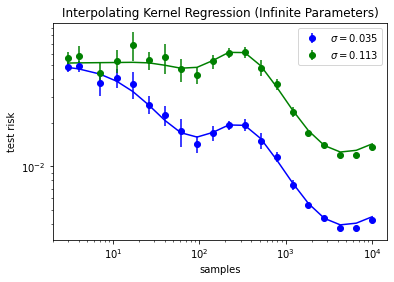

[0.03541849 0.11268516]
 P = 3, gen error: 0.0496 | train error: 4.419e-15 | Time Elapsed: 0h 0m 58s


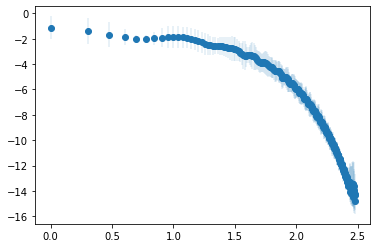

 P = 4, gen error: 0.0475 | train error: 1.625e-11 | Time Elapsed: 0h 0m 58s


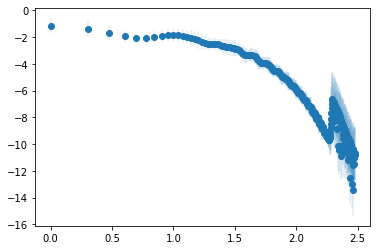

 P = 7, gen error: 0.0399 | train error: 7.763e-16 | Time Elapsed: 0h 1m 0s


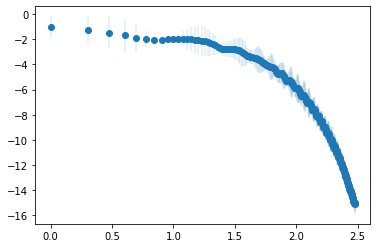

 P = 11, gen error: 0.0380 | train error: 7.600e-16 | Time Elapsed: 0h 0m 59s


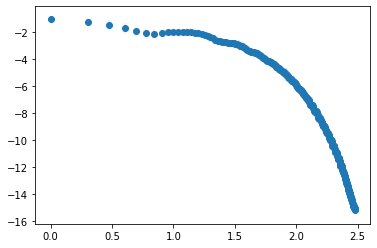

 P = 17, gen error: 0.0385 | train error: 6.624e-16 | Time Elapsed: 0h 0m 57s


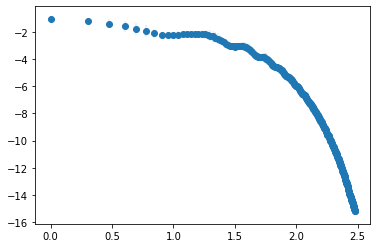

 P = 26, gen error: 0.0264 | train error: 8.029e-16 | Time Elapsed: 0h 0m 58s


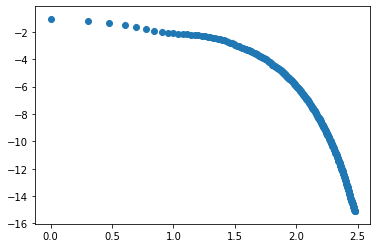

 P = 40, gen error: 0.0232 | train error: 8.148e-16 | Time Elapsed: 0h 0m 58s


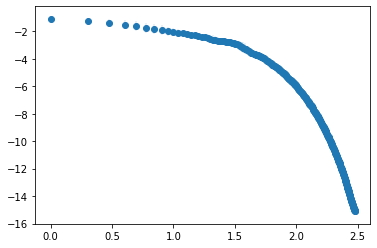

 P = 61, gen error: 0.0179 | train error: 1.037e-15 | Time Elapsed: 0h 0m 58s


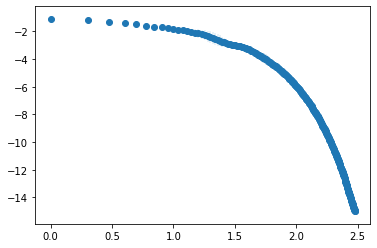

 P = 94, gen error: 0.0146 | train error: 1.844e-15 | Time Elapsed: 0h 0m 58s


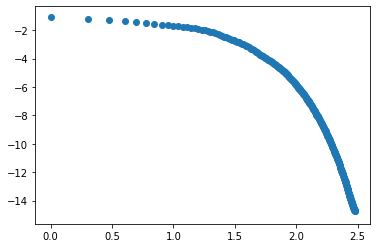

 P = 143, gen error: 0.0167 | train error: 8.158e-15 | Time Elapsed: 0h 0m 57s


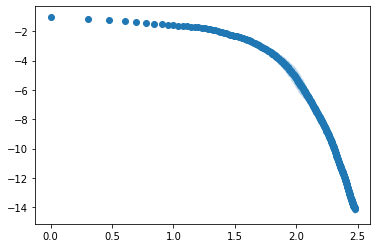

 P = 219, gen error: 0.0187 | train error: 9.121e-11 | Time Elapsed: 0h 0m 57s


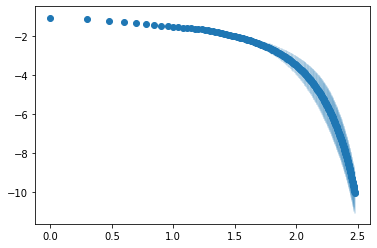

 P = 335, gen error: 0.0192 | train error: 1.434e-06 | Time Elapsed: 0h 0m 57s


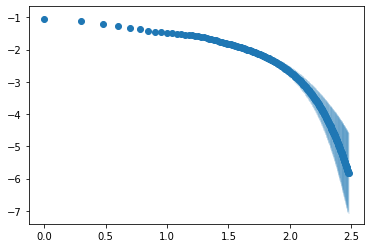

 P = 513, gen error: 0.0155 | train error: 9.704e-05 | Time Elapsed: 0h 0m 57s


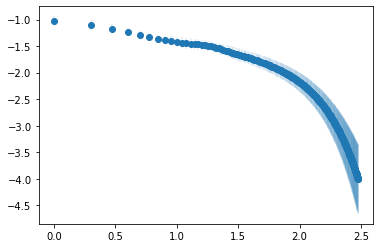

 P = 784, gen error: 0.0121 | train error: 6.760e-04 | Time Elapsed: 0h 0m 57s


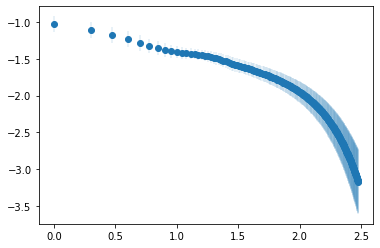

 P = 1199, gen error: 0.0083 | train error: 7.756e-15 | Time Elapsed: 0h 7m 51s


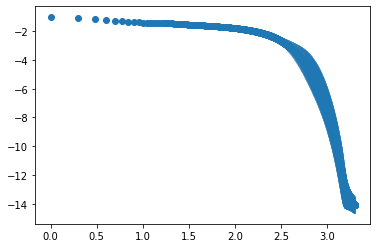

 P = 1832, gen error: 0.0062 | train error: 4.393e-09 | Time Elapsed: 0h 6m 6s


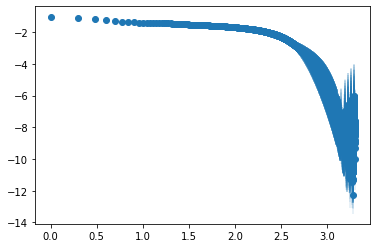

 P = 2801, gen error: 0.0056 | train error: 3.845e-06 | Time Elapsed: 0h 6m 2s


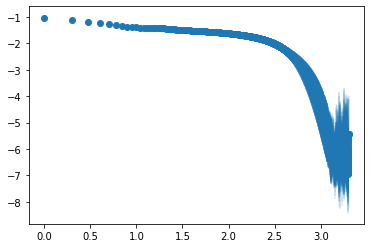

 P = 4281, gen error: 0.0055 | train error: 4.172e-06 | Time Elapsed: 0h 7m 16s


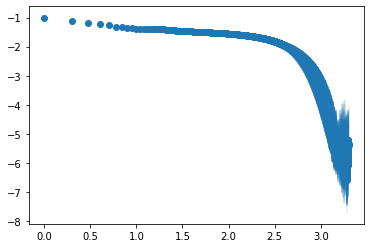

 P = 6543, gen error: 0.0062 | train error: 5.396e-06 | Time Elapsed: 0h 9m 31s


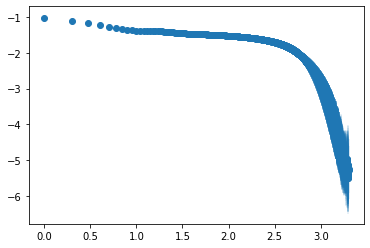

 P = 10000, gen error: 0.0076 | train error: 6.402e-05 | Time Elapsed: 0h 11m 49s


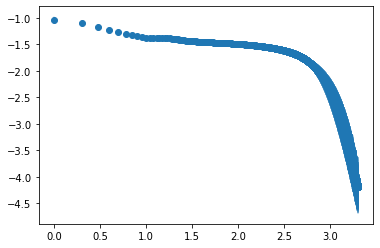

Total Time Elapsed: 1h 2m 19s


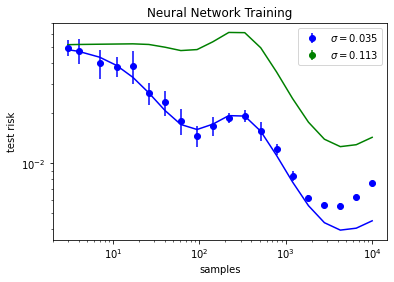

[0.03541849 0.11268516]
 P = 3, gen error: 0.0560 | train error: 1.372e-07 | Time Elapsed: 0h 0m 56s


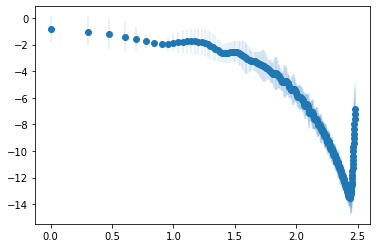

 P = 4, gen error: 0.0536 | train error: 1.169e-15 | Time Elapsed: 0h 0m 56s


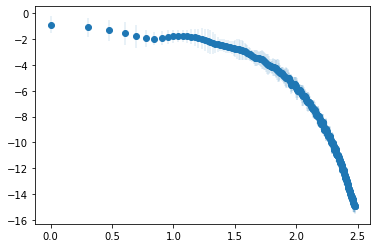

 P = 7, gen error: 0.0473 | train error: 1.429e-15 | Time Elapsed: 0h 0m 56s


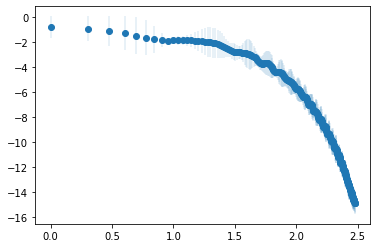

 P = 11, gen error: 0.0492 | train error: 1.584e-15 | Time Elapsed: 0h 0m 57s


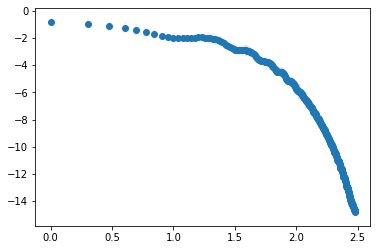

 P = 17, gen error: 0.0660 | train error: 1.659e-15 | Time Elapsed: 0h 0m 56s


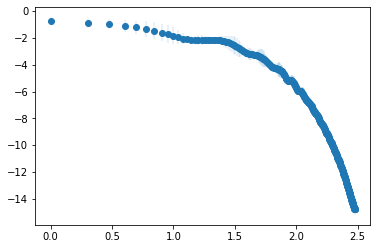

 P = 26, gen error: 0.0507 | train error: 1.482e-15 | Time Elapsed: 0h 0m 57s


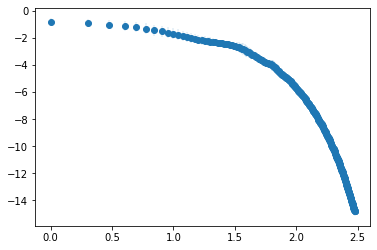

 P = 40, gen error: 0.0540 | train error: 1.652e-15 | Time Elapsed: 0h 0m 56s


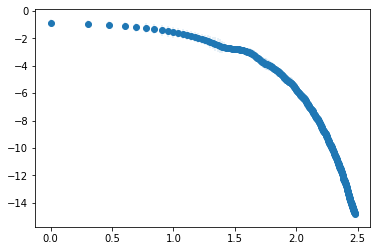

 P = 61, gen error: 0.0462 | train error: 2.719e-15 | Time Elapsed: 0h 0m 56s


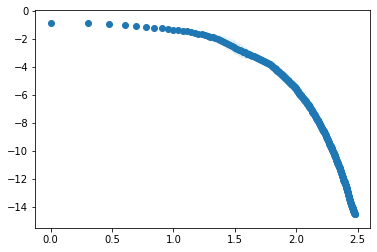

 P = 94, gen error: 0.0417 | train error: 7.580e-15 | Time Elapsed: 0h 0m 57s


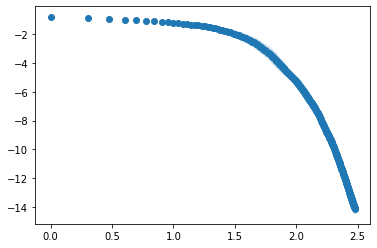

 P = 143, gen error: 0.0524 | train error: 1.845e-13 | Time Elapsed: 0h 0m 56s


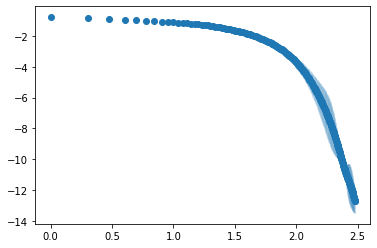

 P = 219, gen error: 0.0619 | train error: 3.719e-08 | Time Elapsed: 0h 0m 57s


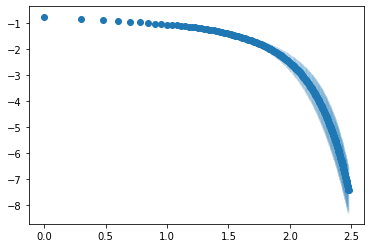

 P = 335, gen error: 0.0649 | train error: 2.557e-05 | Time Elapsed: 0h 0m 57s


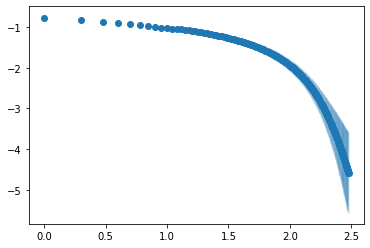

 P = 513, gen error: 0.0521 | train error: 6.302e-04 | Time Elapsed: 0h 0m 56s


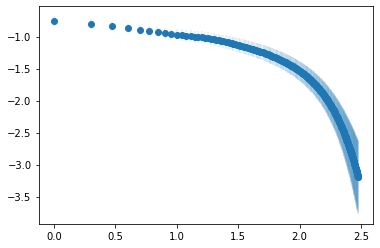

 P = 784, gen error: 0.0402 | train error: 3.200e-03 | Time Elapsed: 0h 0m 56s


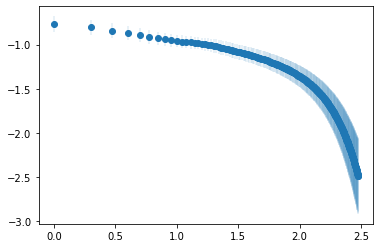

 P = 1199, gen error: 0.0273 | train error: 1.355e-14 | Time Elapsed: 0h 6m 3s


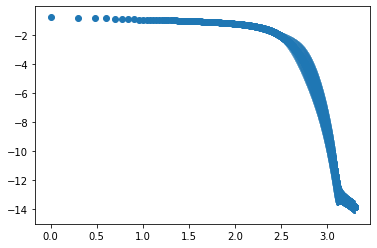

 P = 1832, gen error: 0.0202 | train error: 7.617e-08 | Time Elapsed: 0h 6m 1s


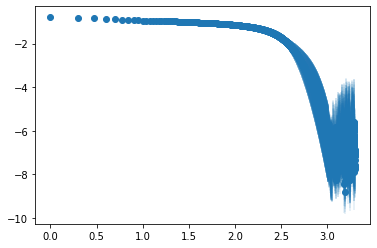

 P = 2801, gen error: 0.0181 | train error: 4.427e-06 | Time Elapsed: 0h 5m 59s


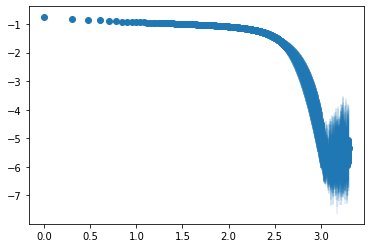

 P = 4281, gen error: 0.0178 | train error: 3.009e-06 | Time Elapsed: 0h 7m 14s


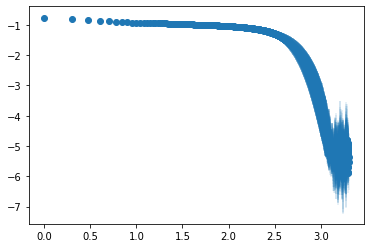

 P = 6543, gen error: 0.0204 | train error: 1.290e-05 | Time Elapsed: 0h 9m 30s


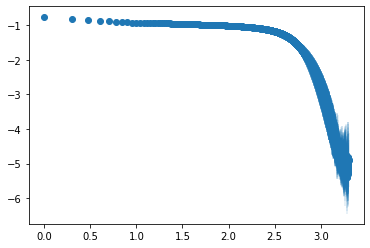

 P = 10000, gen error: 0.0251 | train error: 6.933e-05 | Time Elapsed: 0h 11m 49s


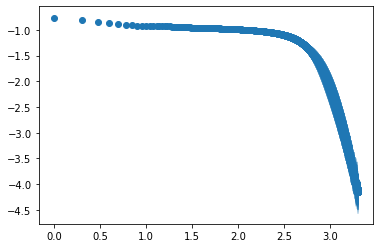

Total Time Elapsed: 0h 59m 55s


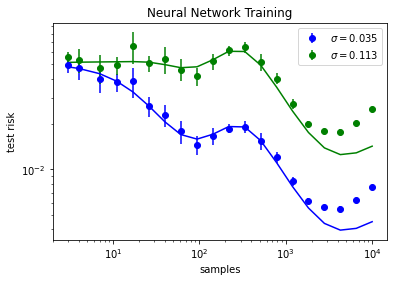

[0.03541849 0.11268516]


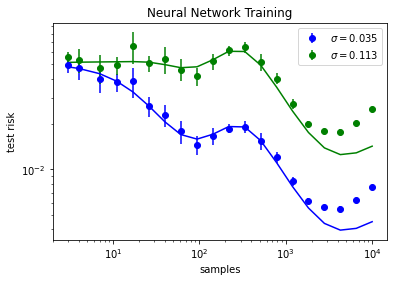

[0.03541849 0.11268516]


In [34]:
timestamp = time_now()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Experiment Parameters
num_repeats_ker = 5 #150
num_repeats_nn = 5 #5
num_iter_nn = 300 #3000

## NN Hyperparameters
lr = 0.005
width = 5000
ensemble_size = 5

## Dimension, sample sizes, max eigenvalue mode
dim = 20
pvals = npo.logspace(0.5, 4, num = 20).astype('int')
p_test = 1500
kmax = 200

## Target function mode and label noise
fn_mode = 1
noise_num = 1
shift = npo.array([-0.8, 0])

key = random.PRNGKey(0)
all_keys = random.split(key, max(num_repeats_nn, num_repeats_ker))

if save_data:
  parent = 'trial/width_depth_experiment_%d_width/'%width
  if os.path.exists(parent) is False:
      os.makedirs(parent)

for layers in [1]:
  if save_data:
    directory = parent + 'layer_%d-fn_mode_%d/'%(layers,fn_mode)
    if os.path.exists(directory) is False:
      os.makedirs(directory)

  # create NN and kernel function
  init_fn, apply_fn, kernel_fn = fully_connected(layers, width)
  apply_fn = jit(apply_fn)
  kernel_fn = jit(kernel_fn, static_argnums=(2,))

  # Generate Theory curves and Noise

  Sol, Errs_tot, noise, alpha_s, spectrum, degens = NTK_theory_and_Noise(pvals, layers, dim, kmax, noise_num, shift, 
                                                                         fn_mode = fn_mode, zero_mode=False)

  params = {'dim': dim, 'kmax': kmax, 'layer': layers, 'width': width,
            'test_samp': p_test, 'num_repeat_ker': num_repeats_ker, 
            'num_repeat_nn': num_repeats_nn, 'num_iter_nn': num_iter_nn, 
            'noise': noise, 'noise_num': noise_num, 'shift': shift, 
            'ensemble_size': ensemble_size, 'fn_mode': fn_mode, 
            'alpha_s': alpha_s, 'degens': degens}

  filename_theory = directory + timestamp + 'error_theory.npz'
  if save_data: np.savez(filename_theory, pvals, Sol, Errs_tot, params)

  ### Start the kernel experiment

  err_regression = npo.zeros((noise_num, len(shift), len(pvals)))
  std_regression = npo.zeros((noise_num, len(shift), len(pvals)))

  for i in range(noise_num):
    t_start = datetime.now()
    for j in range(len(shift)):
      data = kernel_expt(kernel_fn, pvals, p_test, noise[i, j], dim, spectrum, num_repeats_ker, all_keys, fn_mode = fn_mode)
      err_regression[i, j] = data[0]
      std_regression[i, j] = data[1]
    
    t_end = datetime.now()
    print('Time Elapsed: ' + time_diff(t_start,t_end))

    plot_shift_data(pvals, err_regression, std_regression, Errs_tot, i, noise, directory, timestamp, 'kernel')
    print(noise[i])

  filename_exp = directory + timestamp + 'error_exp_kernel.npz'
  if save_data: np.savez(filename_exp, err_regression, std_regression)

  # NN experiment: repeat the same experiment as before...
  # but now use a parametric 2 layer NN with 500 hidden units

  ### Start Neural Network experiment

  err_NN = npo.zeros((noise_num, len(shift), len(pvals)))
  std_NN = npo.zeros((noise_num, len(shift), len(pvals)))

  tr_err_NN = []
  std_tr_err_NN = []

  for i in range(noise_num):
    for j in range(len(shift)):
      data = nn_expt(init_fn, apply_fn, pvals, p_test, noise[i,j], dim, spectrum, 
                     num_repeats_nn, all_keys, lr, num_iter_nn, 
                     fn_mode = fn_mode, ensemble_size = ensemble_size)
      
      err_NN[i, j] = data[0]
      std_NN[i, j] = data[1]
      tr_err_NN += [data[2]]
      std_tr_err_NN += [data[3]]

      filename_exp = directory + timestamp + 'shift_' + str(j) + '_error_exp_NN.npz'
      if save_data: np.savez(filename_exp, err_NN, std_NN, tr_err_NN, std_tr_err_NN)
      
      plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, directory, timestamp, 'NN')
      print(noise[i])

    plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, directory, timestamp, 'NN')

    print(noise[i])

  filename_exp = directory + timestamp + 'final_error_exp_NN.npz'
  if save_data: np.savez(filename_exp, err_NN, std_NN, tr_err_NN, std_tr_err_NN)

In [ ]:
 plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, directory, timestamp, 'NN')

In [ ]:
directory = 'trial/NNExp_layer1_width1000/'

error_theory = np.load(directory+'error_theory.npz', allow_pickle = True)
error_exp_kernel = np.load(directory+'error_exp_kernel.npz')
error_exp_NN = np.load(directory+'error_exp_NN.npz')

pvals, Sol, Errs_tot, params = [error_theory['arr_'+str(i)] for i in range(len(error_theory.files))]
params = params.tolist()
alpha_s = params['alpha_s']
degens = params['degens']
dim = params['dim']
kmax = params['kmax']
layer = params['layer']
noise = params['noise']
num_iter_nn = params['num_iter_nn']
num_repeat_nn = params['num_repeat_nn']
num_repeat_ker = params['num_repeat_ker']
test_samp = params['test_samp']
width = params['width']

err_regression, std_regression = [error_exp_kernel['arr_'+str(i)] for i in range(len(error_exp_kernel.files))]
err_NN, std_NN, tr_err_NN, std_tr_err_NN = [error_exp_NN['arr_'+str(i)] for i in range(len(error_exp_NN.files))]

shift = np.array([-0.8,0,5])

# plot_shift_data(pvals, err_regression, std_regression, Errs_tot, i, noise, directory, 'kernel')
# plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, directory, 'NN')

FileNotFoundError: ignored

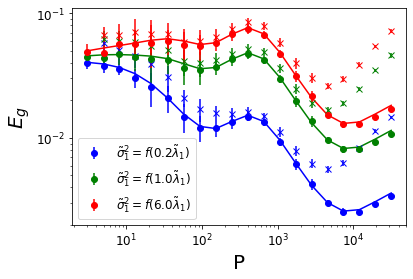

In [ ]:
i = 0
plt.rcParams.update({'font.size': 12})
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(len(shift)):
    k = 1+shift[j]
    plt.errorbar(pvals, err_regression[i,j], std_regression[i,j], fmt='o', label = r'$\tilde\sigma_1^2 = f(%.1f \tilde\lambda_1)$' % k, color=colors[j])
    plt.errorbar(pvals[1:], err_NN[i,j][1:], std_NN[i,j][1:], fmt='x',color=colors[j])
    plt.plot(pvals, Errs_tot[j,:,i], color=colors[j])

plt.xlabel('P', fontsize= 20)
plt.ylabel('$E_g$', fontsize= 20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
timestamp = datetime.now().strftime("%d_%H-%M")
label = timestamp + '_k_' + str(i+1) + '_' + 'error_curve' + '.pdf'
plt.savefig('nn_dim_20_layer_1.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
directory = 'trial/NNExp_layer1_width1000/'

error_theory = np.load(directory+'error_theory.npz', allow_pickle = True)
error_exp_kernel = np.load(directory+'error_exp_kernel.npz')
error_exp_NN = np.load(directory+'error_exp_NN.npz')

pvals, Sol, Errs_tot, params = [error_theory['arr_'+str(i)] for i in range(len(error_theory.files))]
params = params.tolist()
alpha_s = params['alpha_s']
degens = params['degens']
dim = params['dim']
kmax = params['kmax']
layer = params['layer']
noise = params['noise']
num_iter_nn = params['num_iter_nn']
num_repeat_nn = params['num_repeat_nn']
num_repeat_ker = params['num_repeat_ker']
test_samp = params['test_samp']
width = params['width']

err_regression, std_regression = [error_exp_kernel['arr_'+str(i)] for i in range(len(error_exp_kernel.files))]
err_NN, std_NN, tr_err_NN, std_tr_err_NN = [error_exp_NN['arr_'+str(i)] for i in range(len(error_exp_NN.files))]

shift = np.array([-0.8,0,5])

# plot_shift_data(pvals, err_regression, std_regression, Errs_tot, i, noise, directory, 'kernel')
# plot_shift_data(pvals, err_NN, std_NN, Errs_tot, i, noise, directory, 'NN')

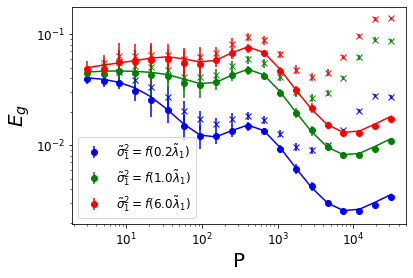

In [ ]:
i = 0
plt.rcParams.update({'font.size': 12})
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(len(shift)):
    k = 1+shift[j]
    plt.errorbar(pvals, err_regression[i,j], std_regression[i,j], fmt='o', label = r'$\tilde\sigma_1^2 = f(%.1f \tilde\lambda_1)$' % k, color=colors[j])
    plt.errorbar(pvals[1:], err_NN[i,j][1:], std_NN[i,j][1:], fmt='x',color=colors[j])
    plt.plot(pvals, Errs_tot[j,:,i], color=colors[j])

plt.xlabel('P', fontsize= 20)
plt.ylabel('$E_g$', fontsize= 20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
timestamp = datetime.now().strftime("%d_%H-%M")
label = timestamp + '_k_' + str(i+1) + '_' + 'error_curve' + '.pdf'
plt.savefig('nn_dim_20_layer_1.pdf', bbox_inches = 'tight')
plt.show()